# GEOG696C Spatiotemporal Data Analysis
## Homework #5
Alex Saunders | Last updated: 30 October 2023

In [19]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, colors
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe
from datetime import datetime
import calendar
import scipy as sp
import xarray as xr
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

In [2]:
# Set the root path
rootPath = Path('C:/Users/alexa/Documents/GitHub/spatiotemporal_data_analysis/00_hw')
dataPath = Path ('C:/Users/alexa/Documents/01_personal/07_phd/05_study/02_courses/2023/1/GEOG696/data')

## 1. Perform a field correlation between winter (DJF) SOI time series and the global DJF 700mb heights and calculate associated p-values

### SOI Data

In [3]:
# Read in the SOI data and prepare it for correation analysis in xarray
soi = xr.open_dataset(dataPath/'soi.nc', mask_and_scale=True, decode_times=False)

In [5]:
soi['time'].attrs['units']

'months since 1866-01-15'

In [11]:
# Change months time unit to a new monthly date range
newTime = pd.date_range('01/01/1866', periods=len(soi['time']), freq='M')
soi["time"]=pd.to_datetime(newTime)
soi = soi["SOI"]
soi["time"] = pd.to_datetime(soi["time"].dt.strftime("%Y-%m"))

In [12]:
# Compute rolling 3 month mean and extract only the rolling periods ending in February
soiRolling = soi.rolling(time=3).mean(skipna=True)
soiDJF = soiRolling[soiRolling.time.dt.month == 2]
soiDJF=soiDJF.drop_isel(time=0)

## 700mb geopotential height data

In [13]:
hgt=xr.open_dataset(dataPath/'hgt.700mb.mon.mean.nc', mask_and_scale=True)
hgt=hgt['hgt']

In [14]:
hgt

<xarray.DataArray 'hgt' (time: 2160, level: 1, lat: 181, lon: 360)>
[140745600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * level    (level) float32 700.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1836-01-01 1836-02-01 ... 2015-12-01
Attributes: (12/15)
    long_name:         Monthly Geopotential Height on Pressure Levels
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             m
    GRIB_name:         HGT
    var_desc:          Geopotential height
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si-mo ...
    ...                ...
    standard_name:     geopotential_height
    valid_range:       [-1500. 60000.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ -307.88  50208.145]

In [15]:
# Get a rolling 3 month window and get averages ending in February
hgtRolling = hgt.rolling(time=3).mean(skipna=True) 
hgtDJF = hgtRolling[hgtRolling.time.dt.month == 2]
hgtDJF = hgtDJF.squeeze(drop=True) 

### Align times of SOI and 700mb data

In [101]:
hgtDJF, soiDJF = xr.align(hgtDJF, soiDJF, join="inner") # hgt and sst now have the same time dimension!

### Compute the field correlation, getting the Pearson r and associated p-values

In [168]:
fieldCorrelation = xr.corr(soiDJF, hgtDJF, dim="time")

# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(soiDJF.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(soiDJF.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue, dims=["lat","lon'"], coords=[fieldCorrelation.lat, fieldCorrelation.lon])

### Plot a map of the field correlation, shading in the 'significant' areas

In [103]:
sigThreshold=0.05

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


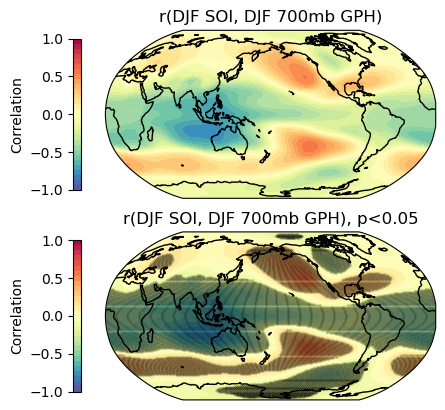

In [104]:
# defines areas with sigificant coefficients
sig_area1   = np.where(sig < sigThreshold) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(hgtDJF.lon, hgtDJF.lat, fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI, DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.50, 0.0, 0.50, 1]) #ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1]
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(hgtDJF.lon, hgtDJF.lat, fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI, DJF 700mb GPH), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.50, 0.0, 0.50, 1])
cb2.set_label('Correlation', fontsize=10) 

ax2.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())

### Count the number of locally significant p-values

In [105]:
nPoints = len(sig)*len(sig[0])

In [106]:
nPointsSigData = np.array([(sig<sigThreshold).sum().values])[0]

In [113]:
nPoints, nPointsSigData

(65160, 34210)

## 2. Design and perform a Monte Carlo test procedure to evaluate whether the field correlation is significant as a whole

We will create a random field for each iteration of the Monte Carlo simulations, by shuffling the time attribute of the spatial fields.

### Run the Monte Carlo simiulations - each time with a random field created by shuffling the time of the 700mb dataset

In [98]:
iterations=1000
nPointsSigAll=[]
for i in range(iterations):
    # Create a shuffled series of years
    timeArray = np.array(hgtDJF.time)
    np.random.shuffle(timeArray)
    
    # Create a 700mb dataset with the new shuffled time component
    hgtDJFShuffled = hgtDJF.copy()
    hgtDJFShuffled['time'] = timeArray
    
    # Repeat the field correlation with the reshuffled 700mb dataset
    fieldCorrelation = xr.corr(soiDJF, hgtDJFShuffled, dim="time")
    
    # calculate the p-values directly using r values and the t-distribution
    t = -abs(fieldCorrelation.values)*np.sqrt((len(soiDJF.time)-2)/(1-np.square(fieldCorrelation.values)))
    pvalue = sp.stats.t.cdf(t, len(soiDJF.time) - 2) * 2 # multiply by 2 for two-sided test
    sig = xr.DataArray(data=pvalue, dims=["lat","lon'"], coords=[fieldCorrelation.lat, fieldCorrelation.lon])
    
    # Record the number of locally significant points
    nPointsSig = np.array([(sig<sigThreshold).sum().values])[0]
    nPointsSigAll.append(nPointsSig)

### Plot the results as a histogram

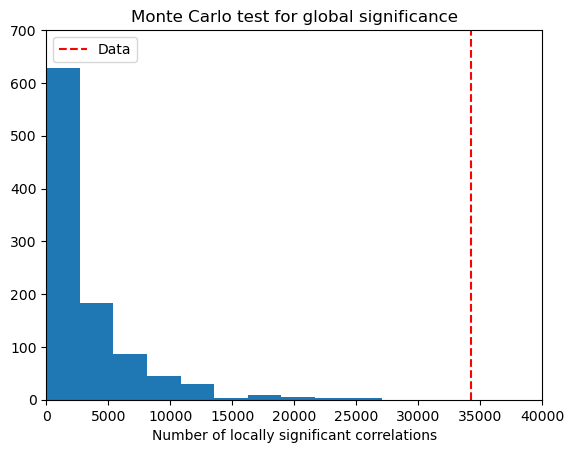

In [112]:
fix, ax= plt.subplots()

ax.hist(nPointsSigAll)
ax.set_title('Monte Carlo test for global significance')
ax.set_xlabel('Number of locally significant correlations')

ax.plot([nPointsSigData, nPointsSigData], [0, 800], 'r--', label='Data')

ax.set_ylim(0,700)
ax.set_xlim(0, 40000)

ax.legend()

plt.show()

### Significance result following Livezey and Chen (1983)

Based on this Monte Carlo approach, the field __is__ globally significant.

## 3. Perform the false discovery rate significance test

In [134]:
# Order the p vales lowest to highest
pValsArray = sig.values.ravel()
pValsArray.sort()

# Create list of i values for p-values
pValsi = range(1, len(pValsArray)+1)

In [146]:
# pValsFDR = sp.stats.false_discovery_control(pValsArray)

### Plot the FDR

In [153]:
import pyleoclim

In [155]:
sigFDRIndices = pyleoclim.utils.correlation.fdr(pValsArray, qlevel=sigThreshold, method='original')

In [165]:
maxSigPValFDR = pValsArray[sigFDRIndices.max()]

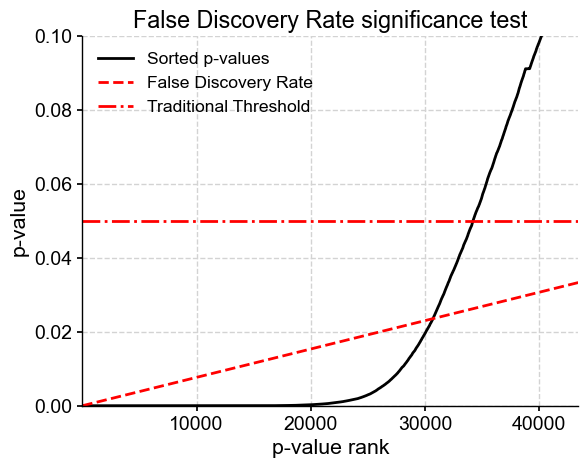

In [162]:
fig, ax = plt.subplots()
ax.set_title('False Discovery Rate significance test')
ax.plot(pValsi, pValsArray ,'k', label='Sorted p-values')
ax.plot([0, len(pValsi)+1], [0, sigThreshold], 'r--', label='False Discovery Rate')
# ax.plot(sigFDRIndices, pValsArray[sigFDRIndices])
# ax.plot(pValsi, pValsFDR, 'r')
ax.plot()
ax.plot([0, len(pValsi)+1], [sigThreshold, sigThreshold], 'r-.', label='Traditional Threshold')
ax.set_ylabel('p-value')
ax.set_xlabel('p-value rank')

ax.set_xlim(1,len(pValsi)+1)
ax.set_xlim(1,round((len(pValsi)+1)/1.5))
ax.set_ylim(0,0.1)

ax.legend()
plt.show()

### Plot a map of the result of the FDR significance

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


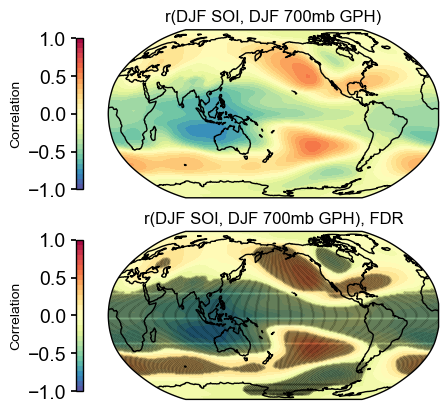

In [169]:
# defines areas with sigificant coefficients
sig_area1   = np.where(sig < maxSigPValFDR) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(hgtDJF.lon, hgtDJF.lat, fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI, DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.50, 0.0, 0.50, 1]) #ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1]
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(hgtDJF.lon, hgtDJF.lat, fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI, DJF 700mb GPH), FDR', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.50, 0.0, 0.50, 1])
cb2.set_label('Correlation', fontsize=10) 

ax2.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())

Now we have number of signifcant points from the data with the 0.05 p-value traditional test and the FDR test

In [176]:
print(nPointsSigData)

34210


In [178]:
nPointsSigFDR = np.array([(sig<maxSigPValFDR).sum().values])[0]
print(nPointsSigFDR)

30701


## 4. Perform a field correlation with monthly mean temperatures and California wine grape harvest

### Read and detrend the wine data

In [185]:
# Open the wine txt file
wine=pd.read_csv(dataPath/'wine_grape_crush.txt', sep='\t')

In [193]:
# Detrend
wineDetrended = sp.signal.detrend(wine[wine.columns[0]], type='linear')

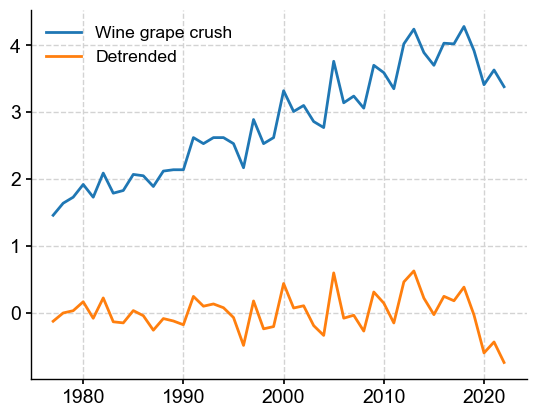

In [195]:
fig, ax =plt.subplots()
ax.plot(wine, label='Wine grape crush')
ax.plot(wine.index, wineDetrended, label='Detrended')
ax.legend()
plt.show()

In [250]:
wine['Date']= [str(item) + '-09-01' for item in wine.index]

In [263]:
# Convert to xarray
wineOrig = xr.DataArray(wine[wine.columns[0]],
                        dims=("time"),
                        coords=[
                            ("time", pd.to_datetime(wine.Date, format="%Y-%m-%d")),
                        ],)

In [251]:
# Convert to xarray
wineDetrended = xr.DataArray(wineDetrended.values,
                        dims=("time"),
                        coords=[
                            ("time", pd.to_datetime(wine.Date, format="%Y-%m-%d")),
                        ],)

### Read the TAVG land and ocean temperature data

In [243]:
# Read in the SOI data and prepare it for correation analysis in xarray
temp = xr.open_dataset(dataPath/'TAVG_landocean_LatLong1.nc', mask_and_scale=True, decode_times=False)

In [244]:
# Change months time unit to a new monthly date range
newTime = pd.date_range('01/01/1850', periods=len(temp.time), freq='M')
temp["time"]=pd.to_datetime(newTime)
temp = temp["temperature"]
temp["time"] = pd.to_datetime(temp["time"].dt.strftime("%Y-%m"))

In [245]:
# Compute rolling 5 month mean and extract only the rolling periods ending in September
tempRolling = temp.rolling(time=5).mean(skipna=True)
tempAvg = tempRolling[tempRolling.time.dt.month == 9]
tempAvg=tempAvg.drop_isel(time=0)

### Correlate the temp and wine data, with the original and trended wine data

In [264]:
fieldCorrelation = xr.corr(wineOrig, tempAvg, dim="time")
# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(wineDetrended.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(wineDetrended.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue, dims=["lat","lon'"], coords=[fieldCorrelation.latitude, fieldCorrelation.longitude])

### Plot a map of the field correlation, shading in the 'significant' areas

In [265]:
sigThreshold=0.05

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


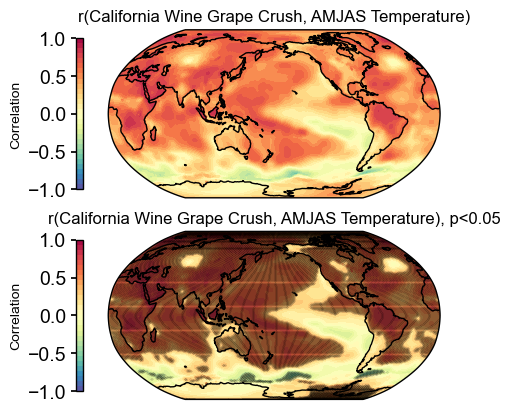

In [267]:
# defines areas with sigificant coefficients
sig_area1   = np.where(sig < sigThreshold) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.longitude, fieldCorrelation.latitude)

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(tempAvg.longitude, tempAvg.latitude, fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(California Wine Grape Crush, AMJAS Temperature)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.50, 0.0, 0.50, 1]) #ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1]
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(tempAvg.longitude, tempAvg.latitude, fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(California Wine Grape Crush, AMJAS Temperature), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.50, 0.0, 0.50, 1])
cb2.set_label('Correlation', fontsize=10) 

ax2.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())

### Now with the detrended wine data

In [268]:
fieldCorrelation = xr.corr(wineDetrended, tempAvg, dim="time")
# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(wineDetrended.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(wineDetrended.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue, dims=["lat","lon'"], coords=[fieldCorrelation.latitude, fieldCorrelation.longitude])

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


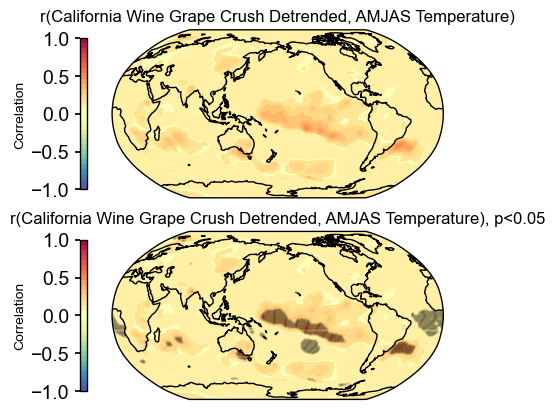

In [270]:
# defines areas with sigificant coefficients
sig_area1   = np.where(sig < sigThreshold) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.longitude, fieldCorrelation.latitude)

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(tempAvg.longitude, tempAvg.latitude, fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(California Wine Grape Crush Detrended, AMJAS Temperature)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.50, 0.0, 0.50, 1]) #ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1]
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(tempAvg.longitude, tempAvg.latitude, fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(California Wine Grape Crush Detrended, AMJAS Temperature), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.50, 0.0, 0.50, 1])
cb2.set_label('Correlation', fontsize=10) 

ax2.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())

__WHat do we see?__ The maps of field correlation without detrending suggest there is strong postiive and statistically significant correlation between the fields. But after detrended the correlation is much more modest, with only a few areas that are deemed to be significant.